In [5]:
!pip install numpy==1.26.4
!pip install pandas==2.1.4

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('car.data')

In [8]:
print(data.columns)

Index(['vhigh', 'vhigh.1', '2', '2.1', 'small', 'low', 'unacc'], dtype='object')


In [3]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
data.columns = col_names
data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [4]:
data['class'].unique()

array(['unacc', 'acc', 'vgood', 'good'], dtype=object)

In [5]:
cat_data = pd.get_dummies(data, columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])
data_x = cat_data.drop('class', axis=1).astype(int)
cat_data['class'] = cat_data['class'].replace(['acc', 'good', 'vgood'], 'acc')
data_y = cat_data['class'].replace({'unacc': 0, 'acc': 1})
print(data_x.shape)
print(data_y.shape)
comb_data = pd.concat([data_x, data_y], axis=1)

(1727, 21)
(1727,)


In [18]:
def train_test_split(data, test_size = 0.2):
    num_samples = len(data)
    num_train_samples = int(num_samples * (1 - test_size))
    num_test_samples = num_samples - num_train_samples

    # Split the dataset
    train_data = data.iloc[:num_train_samples]
    test_data = data.iloc[num_train_samples:]

    # Extract features and target for training and testing sets
    X_train = train_data.iloc[:, :-1].values.astype('int64')
    y_train = train_data.iloc[:, -1].values.astype('int64')
    X_test = test_data.iloc[:, :-1].values.astype('int64')
    y_test = test_data.iloc[:, -1].values.astype('int64')

    return X_train, X_test, y_train, y_test

In [28]:
X_train, X_test, y_train, y_test = train_test_split(comb_data, test_size = 0.2)
print(X_train.shape)
print(y_train.shape)

(1381, 21)
(1381,)


In [20]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index  # Index of the feature to split on
        self.threshold = threshold          # Threshold value for the feature
        self.left = left                    # Left child node
        self.right = right                  # Right child node
        self.value = value                  # Value (class) if the node is a leaf

class DecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth                  # Maximum depth of the tree
        self.min_samples_split = min_samples_split  # Minimum number of samples required to split a node

    def fit(self, X, y):
        self.num_classes = len(np.unique(y))
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_samples_per_class = [np.sum(y == i) for i in range(self.num_classes)]
        majority_class = np.argmax(num_samples_per_class)

        # Stopping criteria
        if (self.max_depth is not None and depth == self.max_depth) or \
           (np.sum(y == y[0]) == len(y)) or \
           (num_samples < self.min_samples_split):
            return Node(value=majority_class)

        best_gini = float('inf')
        best_feature_index = None
        best_threshold = None

        for feature_index in range(num_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices = np.where(X[:, feature_index] <= threshold)[0]
                right_indices = np.where(X[:, feature_index] > threshold)[0]

                left_gini = self._gini_impurity(y[left_indices])
                right_gini = self._gini_impurity(y[right_indices])

                gini = (len(left_indices) / num_samples) * left_gini + \
                       (len(right_indices) / num_samples) * right_gini

                if gini < best_gini:
                    best_gini = gini
                    best_feature_index = feature_index
                    best_threshold = threshold

        if best_gini == float('inf'):
            return Node(value=majority_class)

        left_indices = np.where(X[:, best_feature_index] <= best_threshold)[0]
        right_indices = np.where(X[:, best_feature_index] > best_threshold)[0]

        left_subtree = self._grow_tree(X[left_indices, :], y[left_indices], depth + 1)
        right_subtree = self._grow_tree(X[right_indices, :], y[right_indices], depth + 1)

        return Node(feature_index=best_feature_index, threshold=best_threshold,
                    left=left_subtree, right=right_subtree)

    def _gini_impurity(self, y):
        num_samples = len(y)
        if num_samples == 0:
            return 0
        p = np.bincount(y) / num_samples
        return 1 - np.sum(p ** 2)

    def predict(self, X):
        return np.array([self._predict_tree(x, self.root) for x in X])

    def _predict_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._predict_tree(x, node.left)
        else:
            return self._predict_tree(x, node.right)


In [21]:
def compute_metrics(y_true, y_pred):
    """
    Compute accuracy, precision, recall, and F1-score.

    Args:
    y_true (numpy.ndarray): The true labels.
    y_pred (numpy.ndarray): The predicted labels.

    Returns:
    dict: Dictionary containing accuracy, precision, recall, and F1-score.
    """
    # Compute accuracy
    accuracy = np.mean(y_true == y_pred)

    # Compute confusion matrix
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))

    # Compute precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Compute recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Compute F1-score
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score}


In [22]:
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [24]:
def print_decision_tree(node, indent=""):
    if node is None:
        return
    
    # If it's a leaf node, print the predicted class
    if node.value is not None:
        print(indent + "Leaf Node - Predicted Class:", node.value)
    else:
        # Print splitting criteria
        print(indent + "Internal Node - Splitting Criteria: Feature", node.feature_index, "Threshold:", node.threshold)
        
        # Recursively print left and right subtrees
        print(indent + "Left Subtree:")
        print_decision_tree(node.left, indent + "  ")
        print(indent + "Right Subtree:")
        print_decision_tree(node.right, indent + "  ")

# Example usage:
print("Decision Tree:")
print_decision_tree(clf.root)

Decision Tree:
Internal Node - Splitting Criteria: Feature 12 Threshold: 0
Left Subtree:
  Internal Node - Splitting Criteria: Feature 19 Threshold: 0
  Left Subtree:
    Internal Node - Splitting Criteria: Feature 2 Threshold: 0
    Left Subtree:
      Internal Node - Splitting Criteria: Feature 7 Threshold: 0
      Left Subtree:
        Leaf Node - Predicted Class: 1
      Right Subtree:
        Leaf Node - Predicted Class: 0
    Right Subtree:
      Internal Node - Splitting Criteria: Feature 17 Threshold: 0
      Left Subtree:
        Leaf Node - Predicted Class: 1
      Right Subtree:
        Leaf Node - Predicted Class: 1
  Right Subtree:
    Leaf Node - Predicted Class: 0
Right Subtree:
  Leaf Node - Predicted Class: 0


In [25]:
metrices = compute_metrics(y_test, y_pred)
print(metrices)

{'accuracy': 0.953757225433526, 'precision': 0.9583333333333334, 'recall': 0.9324324324324325, 'f1_score': 0.9452054794520548}


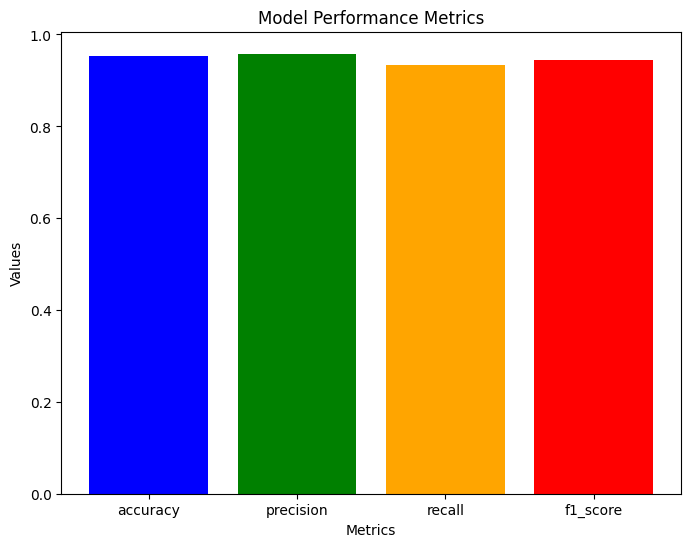

In [26]:
def plot_metrics(metrics):
    """
    Plot the metrics.

    Args:
    metrics (dict): Dictionary containing accuracy, precision, recall, and F1-score.
    """
    labels = list(metrics.keys())
    values = list(metrics.values())

    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Model Performance Metrics')
    plt.show()

# Plot the metrics
plot_metrics(metrices)

In [ ]:
# Plot true values
plt.scatter(range(len(y_test)), y_test, color='blue', label='True', marker='o')

# Plot predicted values
plt.scatter(range(len(y_pred)), y_pre, color='red', label='Predicted', marker='x')

plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.title('True vs Predicted Values')
plt.legend()
plt.savefig('true vs predicted plot.jpg')